# Connection modeling
In this notebook we suggest modeling connections as models. It is supposed that edges are directed and represnted by triplet of the form $(s,d,f)$ where $s,d\in V$ are vertices and $f:\mathbb{R}\to\mathbb{R}$ maps activation level in $t-1$ on $s$ to activation level on $d$ at $t$.
## Hypothesis
The key hypothesis which is analysed in this notebook is that a neural network in a hippocampus of a rodent has a set of neurons which are specialized on providing data and another set which is speicialized on storing data. Those two groups differ in behaviour during arena exploration. We would further try to idnetify and anlyze the beahviour of this groups by trying to predict the learning process of those groups.

In [1]:
import math

import pandas as pd
import numpy as np
from typing import Callable, List, Tuple, Dict, Iterable, Any, Optional
from collections import defaultdict
from scipy.stats import pearsonr
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
from statsmodels.tsa.stattools import grangercausalitytests
from utils import time_consuming, any_in
from utils.preprocessing import standardize_df
from tqdm.notebook import tqdm
from scipy.signal import coherence
import seaborn as sns
import igraph as ig

In [2]:
ig.config["plotting.backend"] = "matplotlib"
ig.config["plotting.layout"] = "fruchterman_reingold"
ig.config["plotting.palette"] = "rainbow"

In [3]:
df = pd.read_csv("../data/22ht3.csv")
df.head()

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,time_s,x,y,0.0,1.0,2.0,3.0,...,509.0,510.0,511.0,512.0,513.0,514.0,515.0,516.0,517.0,518.0
0,0,0,0,67.70,876.202246,701.980008,-0.34655,-0.71631,-0.047737,0.793520,...,1.08940,-1.43040,1.28950,-1.73120,12.296000,0.490490,1.78360,-1.9901,-0.73521,2.0794
1,1,1,1,67.75,873.823553,698.247808,-0.46934,-0.72462,-0.026651,0.232830,...,0.37633,-2.80540,1.04790,-0.64049,7.207100,0.038311,1.26940,-2.3953,-0.62211,-2.9352
2,2,2,2,67.80,869.339334,684.910311,-0.79277,-0.90364,-0.063160,0.637430,...,0.38806,-2.21760,0.41558,-1.91790,8.628700,1.324600,1.81450,-1.8960,-0.47870,-1.2518
3,3,3,3,67.85,870.531773,678.403344,-1.04160,-1.10340,-0.197860,0.010588,...,0.42846,-2.65280,1.07950,-0.65687,6.032800,-1.038900,0.66639,-2.1342,-0.74338,-2.1278
4,4,4,4,67.90,873.077049,680.866207,-0.85335,-0.46933,0.164510,-0.079999,...,0.40836,0.80766,1.26150,-2.46150,-17.125999,0.016407,1.18670,-1.9257,-0.14995,-7.3924


# Data preprocessing
Here we prepare our data by scaling all variables in min-max way.

In [4]:
df = df.drop(["Unnamed: 0", "Unnamed: 0.2", "Unnamed: 0.1"], axis=1)
df_no_time = df.drop(["time_s"], axis=1)
df_norm = standardize_df(df_no_time)
df_norm = df_norm.assign(time_s=df.time_s)
df_norm

,x,y,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,...,510.0,511.0,512.0,513.0,514.0,515.0,516.0,517.0,518.0,time_s
0,0.707681,0.674414,0.019897,0.043888,0.049243,0.096324,0.112920,0.082477,0.136665,0.160537,...,0.349561,0.326807,0.198808,0.361026,0.331943,0.622760,0.151974,0.223625,0.363966,67.70
1,0.703936,0.670267,0.017008,0.043645,0.050695,0.069473,0.092660,0.078581,0.155205,0.156131,...,0.307666,0.311243,0.246539,0.304999,0.320617,0.575973,0.104238,0.246286,0.216556,67.75
2,0.696875,0.655447,0.009400,0.038416,0.048181,0.088849,0.097853,0.082543,0.146584,0.157218,...,0.325576,0.270506,0.190638,0.320651,0.352835,0.625572,0.163060,0.275021,0.266042,67.80
3,0.698753,0.648217,0.003547,0.032582,0.038906,0.058830,0.096063,0.096194,0.152227,0.130040,...,0.312316,0.313278,0.245822,0.292071,0.293635,0.521104,0.134998,0.221988,0.240290,67.85
4,0.702760,0.650954,0.007975,0.051102,0.063859,0.054492,0.091954,0.070946,0.132699,0.132882,...,0.417753,0.325003,0.166849,0.037102,0.320068,0.568448,0.159561,0.340890,0.085531,67.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13867,0.627335,0.669614,0.131957,0.060452,0.075920,0.063369,0.106140,0.088559,0.090102,0.239386,...,0.358985,0.177467,0.250799,0.262381,0.297928,0.454922,0.462753,0.376774,0.271909,761.05
13868,0.627625,0.669290,0.169948,0.057496,0.075044,0.049427,0.109355,0.098269,0.095624,0.248339,...,0.376473,0.324005,0.292048,0.273576,0.276360,0.468932,0.458175,0.331978,0.279592,761.10
13869,0.627959,0.669706,0.182970,0.054578,0.050331,0.069357,0.104534,0.098112,0.087022,0.233656,...,0.391725,0.185280,0.305160,0.280402,0.325606,0.420158,0.483482,0.343217,0.334032,761.15
13870,0.629061,0.672204,0.196220,0.066394,0.063159,0.065946,0.112147,0.089826,0.090092,0.238140,...,0.383360,0.193483,0.242061,0.247040,0.316153,0.462335,0.538800,0.283782,0.360215,761.20


# Sequencing
First of all we should identify the neurons which have high correlation(or actually any other score such as MI or SI) with position of mouse by $\Delta x$ and/or $\Delta y$ and in the same time having low correlation with other neurons in same time but good shifted correlation. Additionally we may expect that so called "input" neurons would have mostly static activation pattern during the learning process.

## By similarity
Suppose we have 2 time series associated with neuron, namely $a_t$ and $b_t$. Let $\rho$ be metric of similarity of $a_t$ and $b_t$. Let $\epsilon$ be some relatively small number. Then we would say that information flows from $a$ to $b$ if $\rho(a_{t}, b_{t+\epsilon}) > \underline\mu$. In this way we may form poset on a set of neurons. Also we may introduce equivalence relation which would mean that neurons are in the same layer. We may say that neurons are equivalent when $\rho(a_t, b_t) > \underline\mu$

In [5]:
# Generic method for building graph
def build_graph(rho: Callable, mu_min: float, n_eps: int = 1,
                exclude_columns: Tuple[str] = ('x', 'y', 'time_s',),
                use_lag: bool = True, dataframe=df_norm,
                figname: Optional[str]=None) -> Dict[str, List[str]]:
    """
    Builg graph with arbitary metrics
    :param use_lag: Whether to lag series
    :param figname: Distirbution figure name to save. Nothing saved if None
    :param dataframe: pd.DataFrame: a dataframe with neuron activity
    :param rho: Callable: metric which accepts two time series and returns float similarity value
    :param mu_min: float: minimal value of metric to state that one neuron activation depends on other
    :param n_eps: int: integer value of epsilon for shifting dataset, takes effect only if lag enabled
    :param exclude_columns: List[str] columns which should be ignored
    :param: use_lag: bool: Whether to lag time series
    :return: Dict[str, List[str]]: graph representation in from of mapping
                                   node name and list of node name it flows to.
    """
    df_neurons = dataframe.drop(list(exclude_columns), axis=1)
    graph = defaultdict(lambda: list())
    rho_avg = 0.0
    n = 0
    rho_values = list()
    for a_column in tqdm(df_neurons.columns):
        if a_column in exclude_columns:
            continue
        for b_column in df_neurons.columns:
            if a_column == b_column:
                continue
            if b_column in exclude_columns:
                continue
            n += 1
            a = df_neurons[a_column]
            b = df_neurons[b_column]
            if use_lag:
                a = a[:-n_eps]
                b = b[n_eps:]
            result = rho(a, b)
            rho_values.append(result)
            rho_avg += result
            if not isinstance(result, float):
                raise TypeError(f"rho should return float, got {result}")
            if result > mu_min:
                graph[a_column].append(b_column)
    if not any_in([None, math.inf, -math.inf], rho_values):
        plt.title("$\\rho$ distribution")
        sns.distplot(rho_values)
        if figname is not None:
            plt.savefig(f"../out/{figname}.png")
        plt.show()
    else:
        print("NaNs detected in rho values, would not build plots")
    return graph

In [6]:
def plot_graph(graph: Dict[str, List[str]]):
    """
    Plots graph with help of networkx
    :param graph: Dict[str, List[str]]: graph representation in from of mapping
                                        node name and list of node name it flows to.
    :return: None
    """
    edges_list = list()
    for src in tqdm(graph):
        dsts = graph[src]
        for dst in dsts:
            edges_list.append([src, dst])
    G = nx.Graph()
    G.add_edges_from(edges_list)
    nx.draw_networkx(G)
    plt.show()

In [7]:
def plot_graph_pyvis(graph: Dict[str, List[str]], name: str="pyvis", dataframe: pd.DataFrame=df_norm):
    """
    Plots graph with help of networkx
    :param dataframe: pd.DataFrame: dataframe on each
    :param name: str: Name of visualisation
    :param graph: Dict[str, List[str]]: graph representation in from of mapping
                                        node name and list of node name it flows to.
    :return: None
    """
    net = Network(notebook=True)
    net.add_nodes(dataframe.columns)
    edges_list = list()
    n = 0
    for src in tqdm(graph):
        dsts = graph[src]
        for dst in dsts:
            edges_list.append([src, dst])
            n += 1
    print("Visualizing %d edges" % len(edges_list))
    print("There is %d nodes in graph" % len(graph.keys()))
    net.add_edges(edges_list)
    net.show(f"../out/{name}.html")

In [8]:
def plot_igraph_to_file(graph: Dict[str, List[str]], fname: str):
    plt.rcParams["figure.figsize"] = (20, 20,)
    g = ig.Graph()
    vetrices = set()
    edges = set()
    for src in tqdm(graph):
        for dst in graph[src]:
            if dst not in vetrices:
                g.add_vertex(dst)
            if src not in vetrices:
                g.add_vertex(src)
            if src == dst:
                continue
            vetrices.add(src)
            vetrices.add(dst)
            if (src, dst,) in edges:
                continue
            edges.add((src, dst,))
            g.add_edge(src, dst)
    #plt.title(fname)
    ig.plot(g)
    plt.savefig(fname + ".png")

### Correlation
Pearson correlation is one of the simplest method to measure similarity between time series.

  0%|          | 0/519 [00:00<?, ?it/s]

/tmp/ipykernel_491/1746057977.py:47: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rho_values)


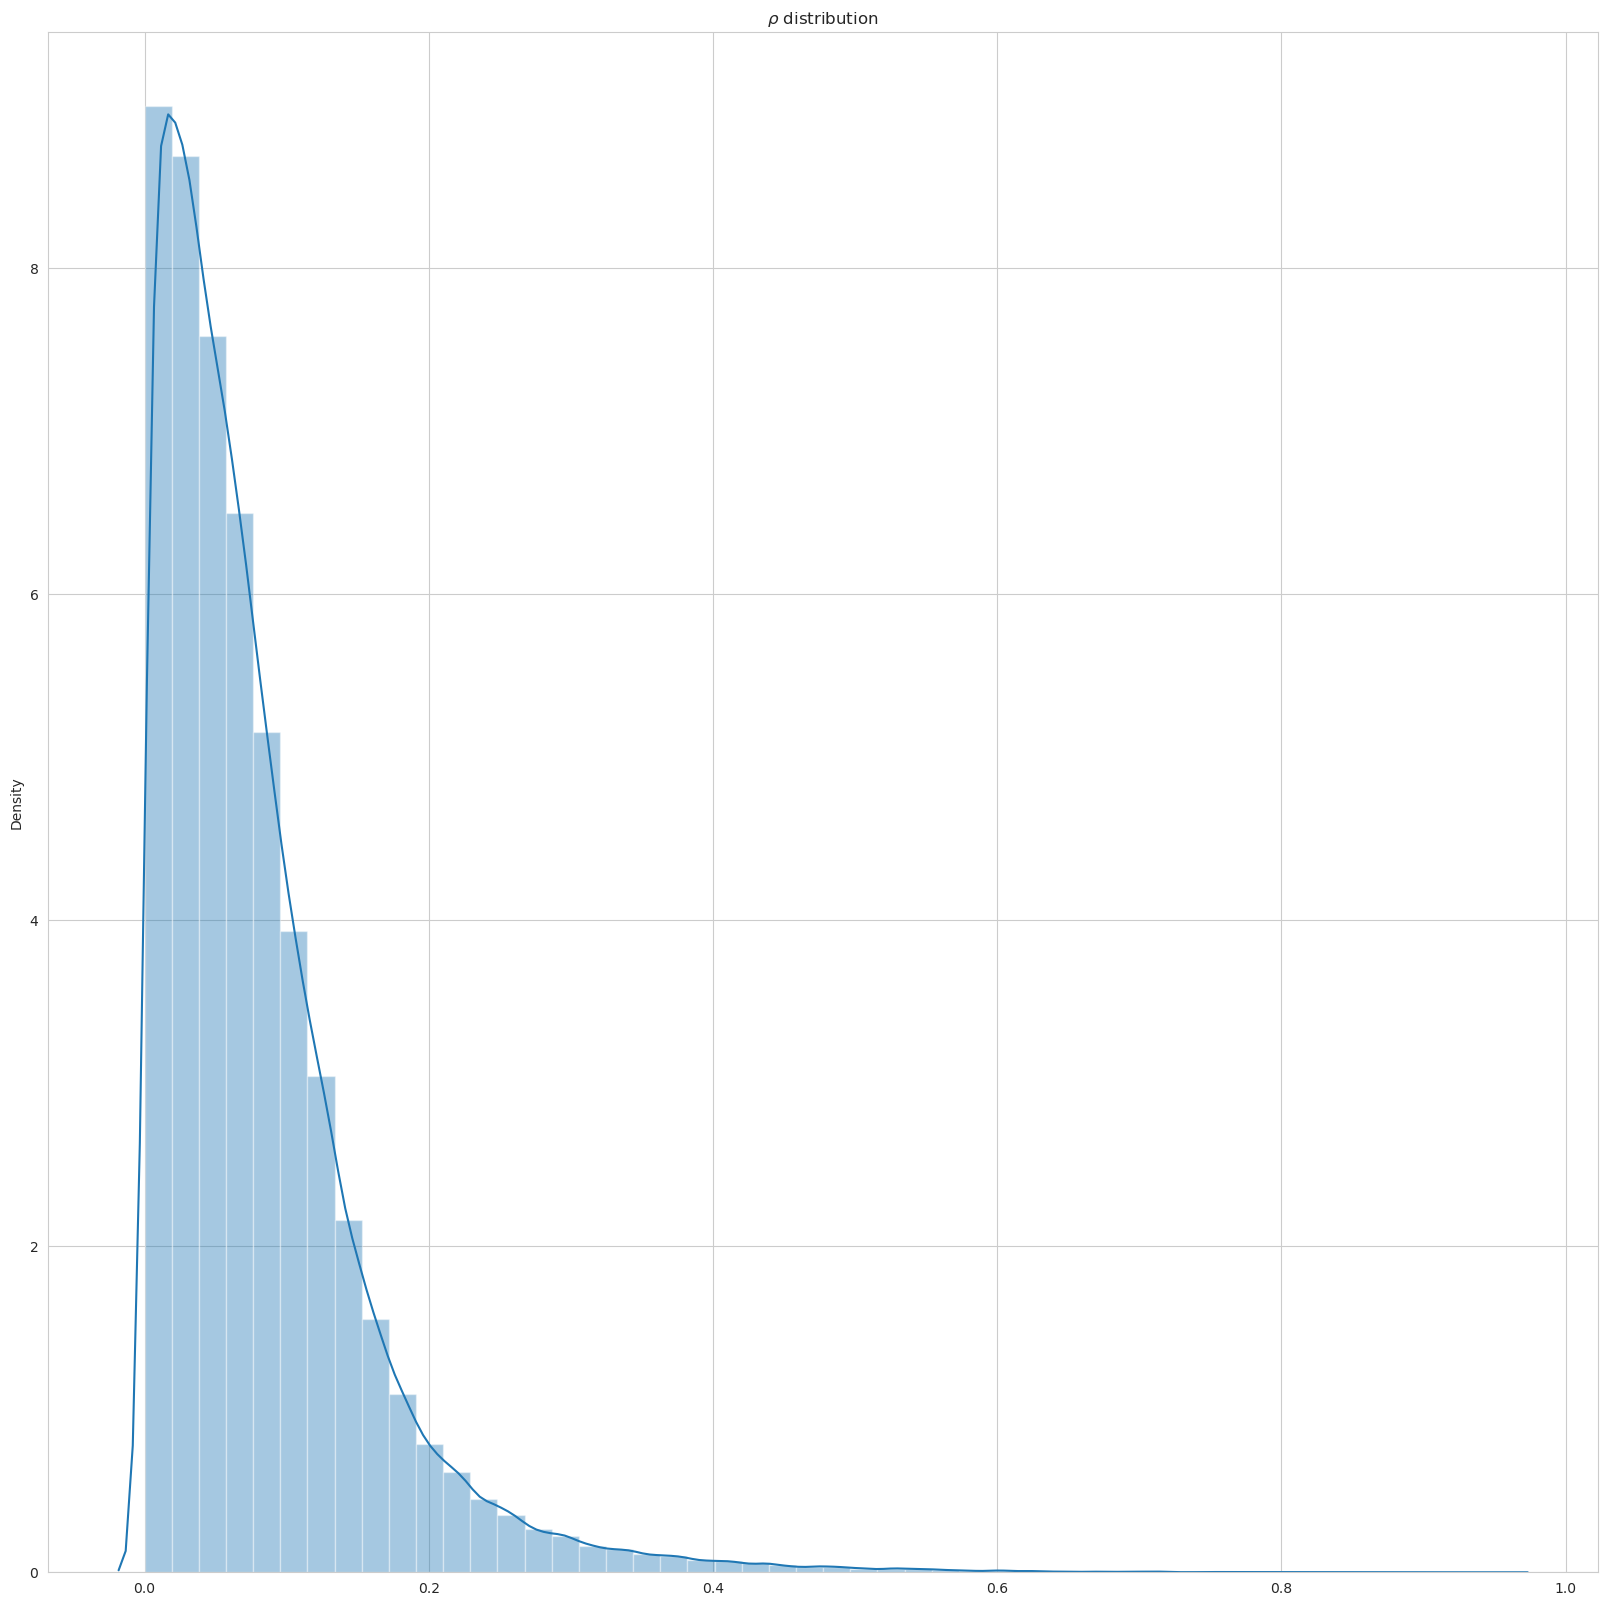

In [17]:
graph = build_graph(lambda a, b: abs(pearsonr(a, b).statistic),
                    0.4, figname="correlation_full_dist")

In [18]:
plot_graph_pyvis(graph, name="correlation_sequencing")

  0%|          | 0/344 [00:00<?, ?it/s]

Visualizing 1867 edges
There is 344 nodes in graph
../out/correlation_sequencing.html


  0%|          | 0/344 [00:00<?, ?it/s]

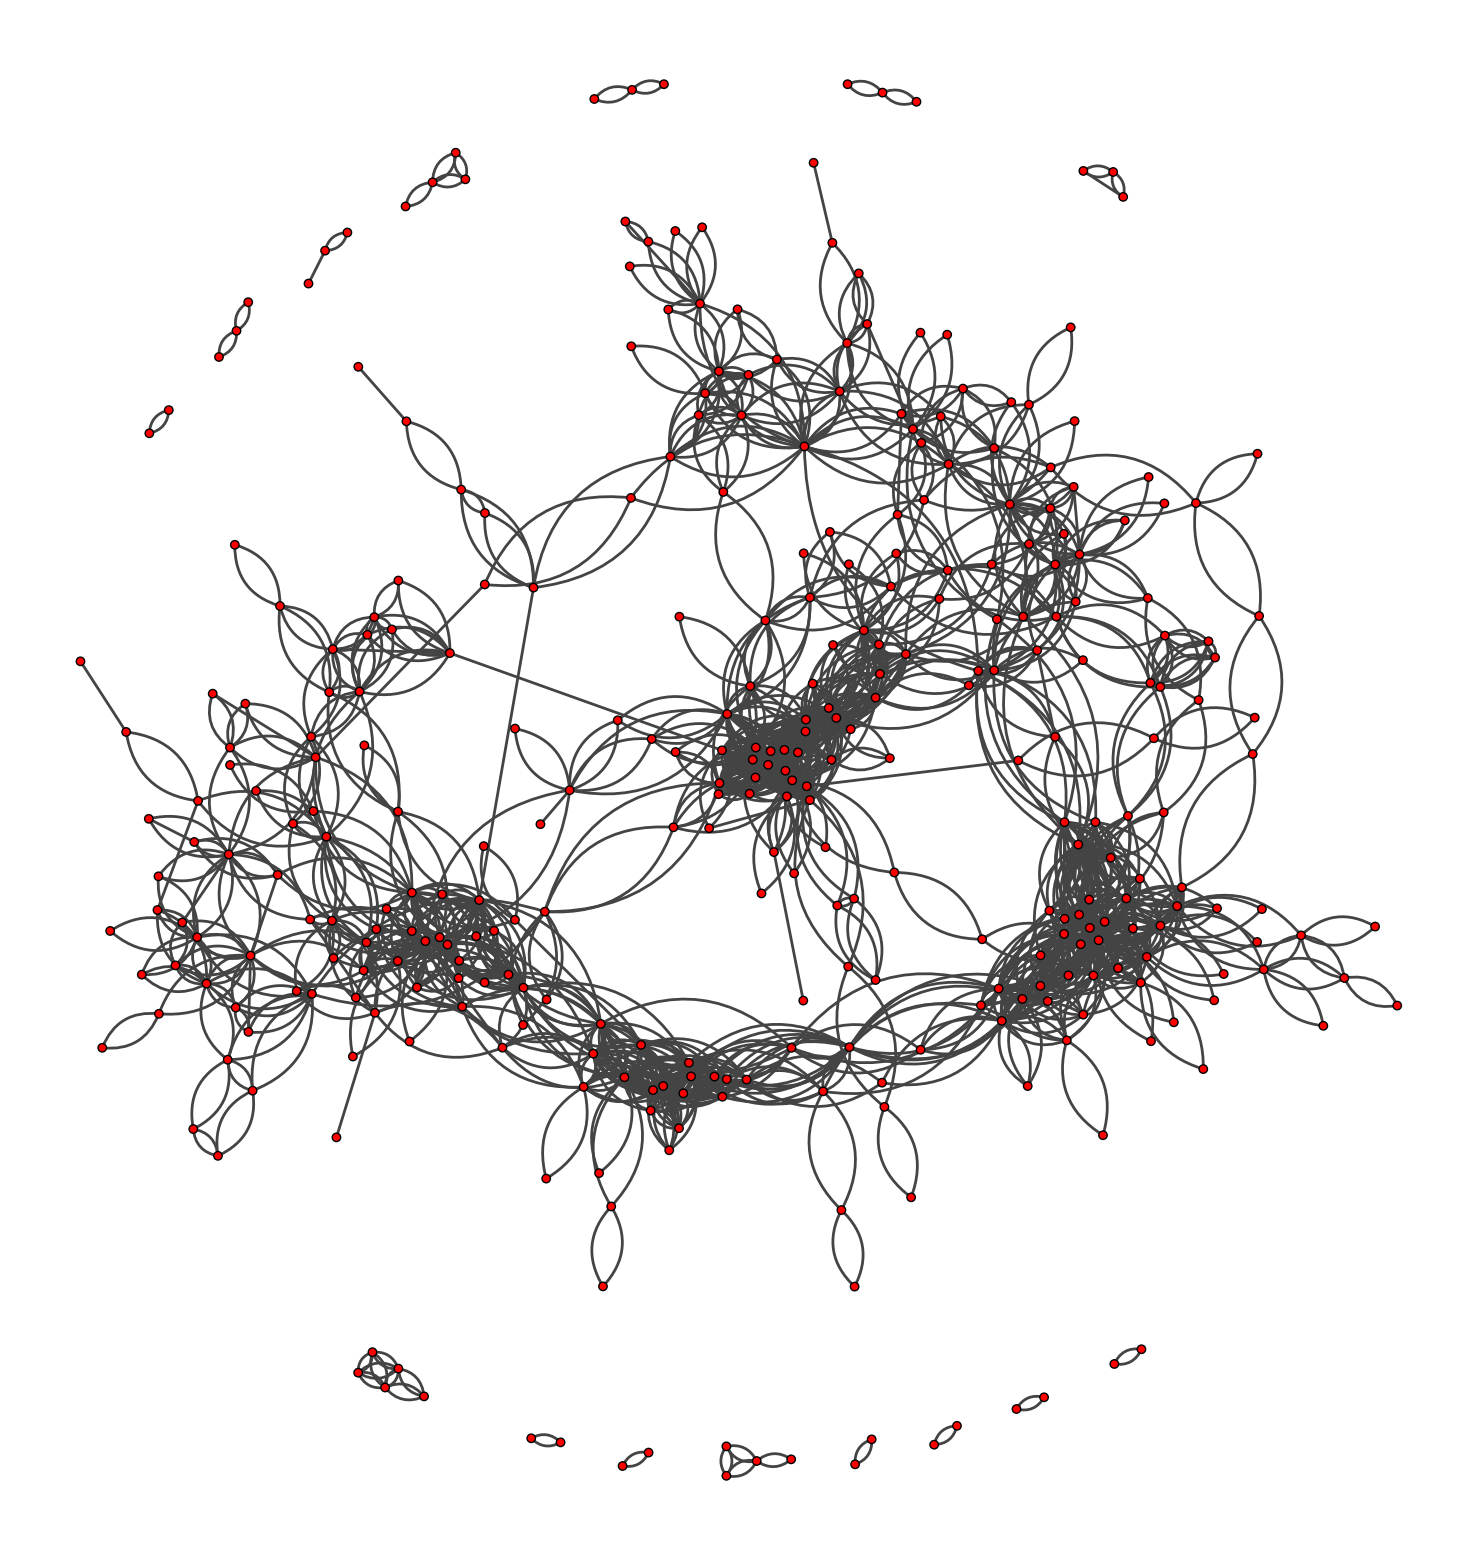

In [19]:
plot_igraph_to_file(graph, fname="../out/correlation_sequencing")

  0%|          | 0/519 [00:00<?, ?it/s]

/tmp/ipykernel_491/1746057977.py:47: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rho_values)


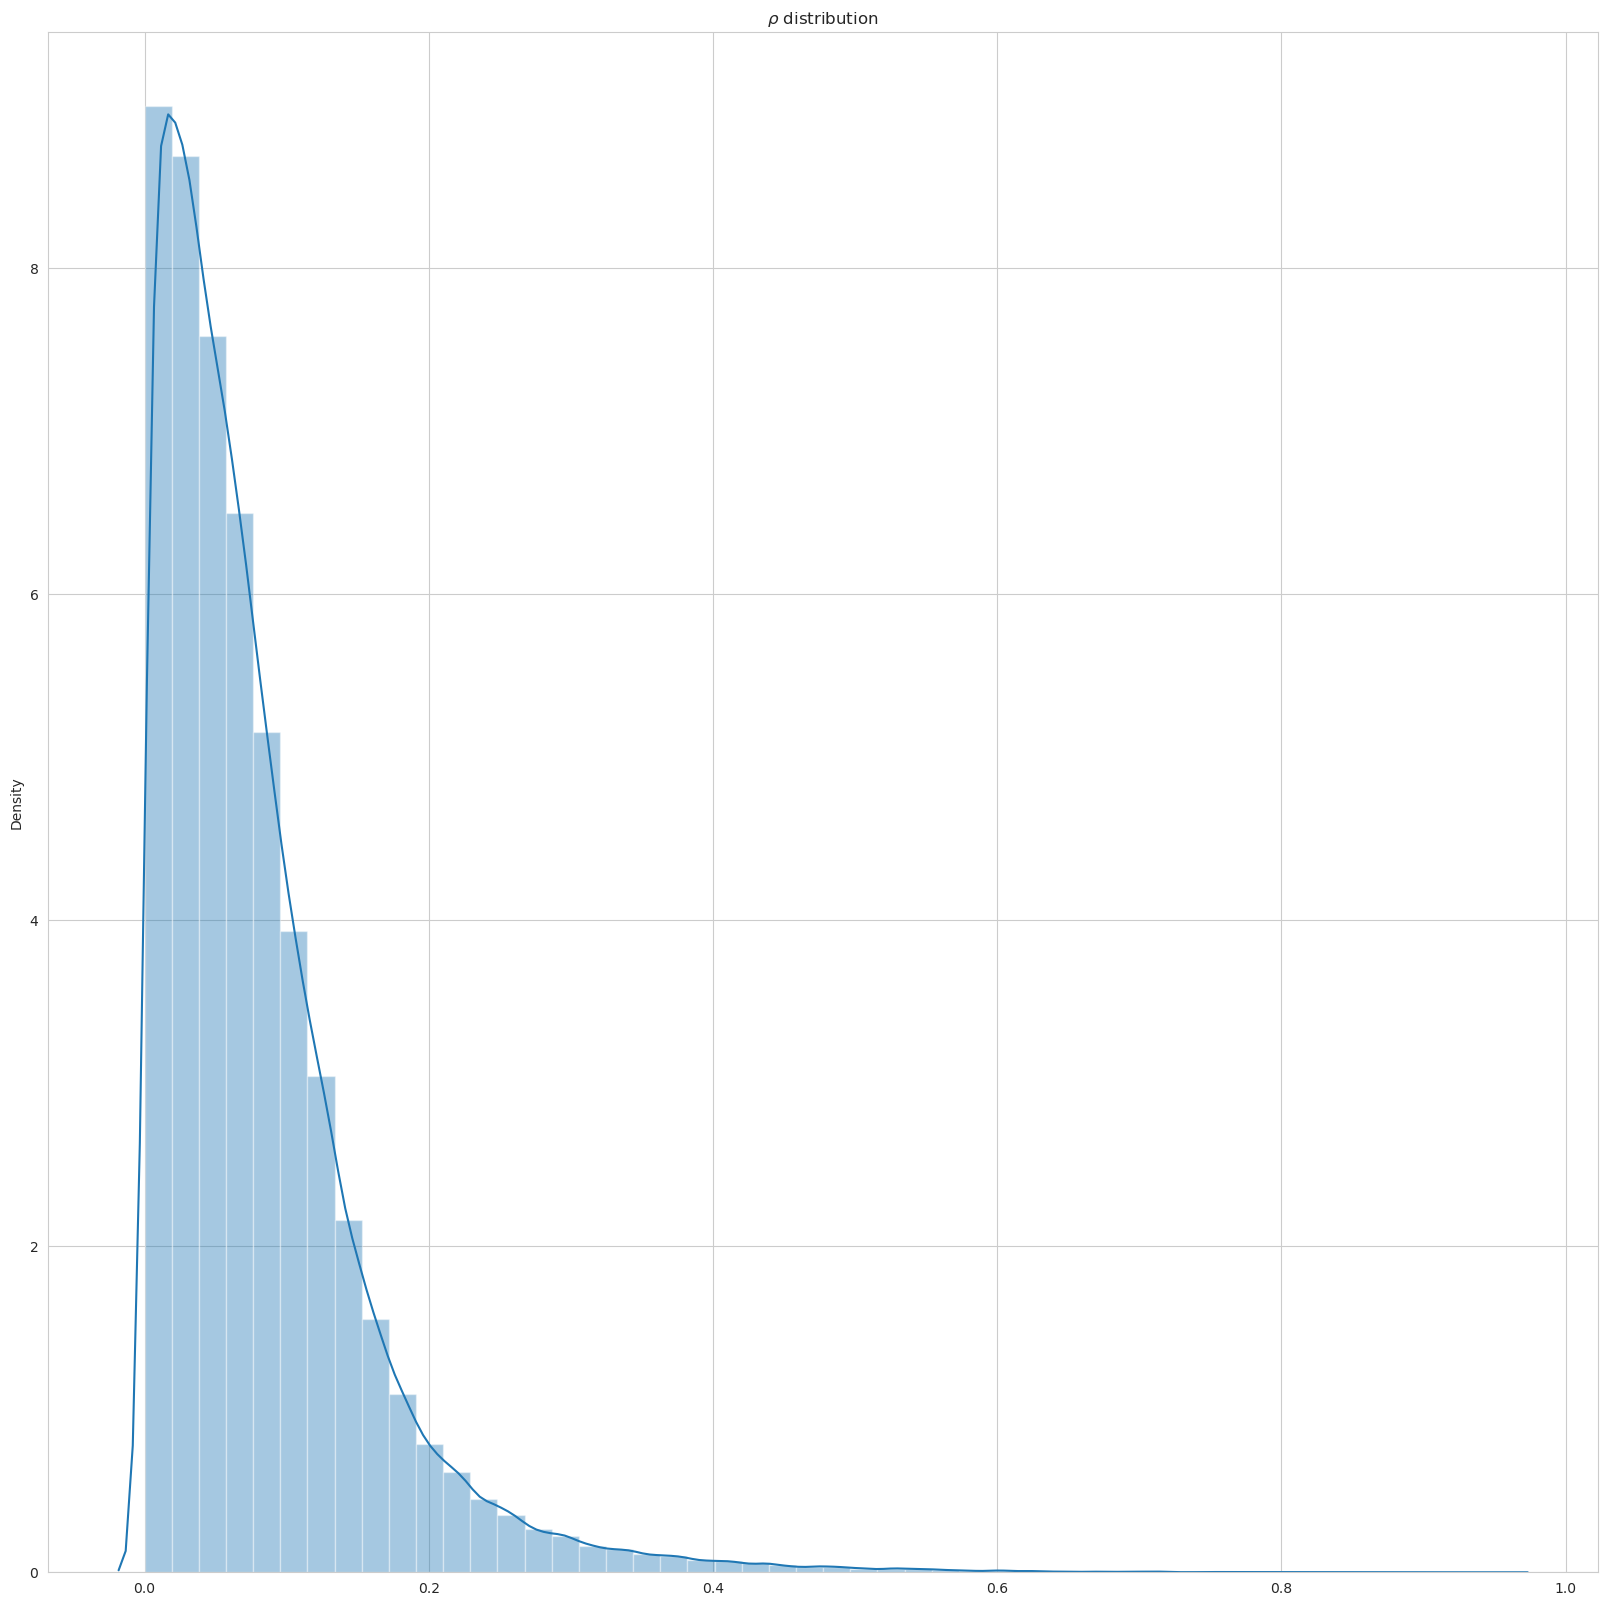

In [22]:
graph = build_graph(lambda a, b: abs(pearsonr(a, b).statistic),
                    0.5, figname="correlation_full_dist")

  0%|          | 0/207 [00:00<?, ?it/s]

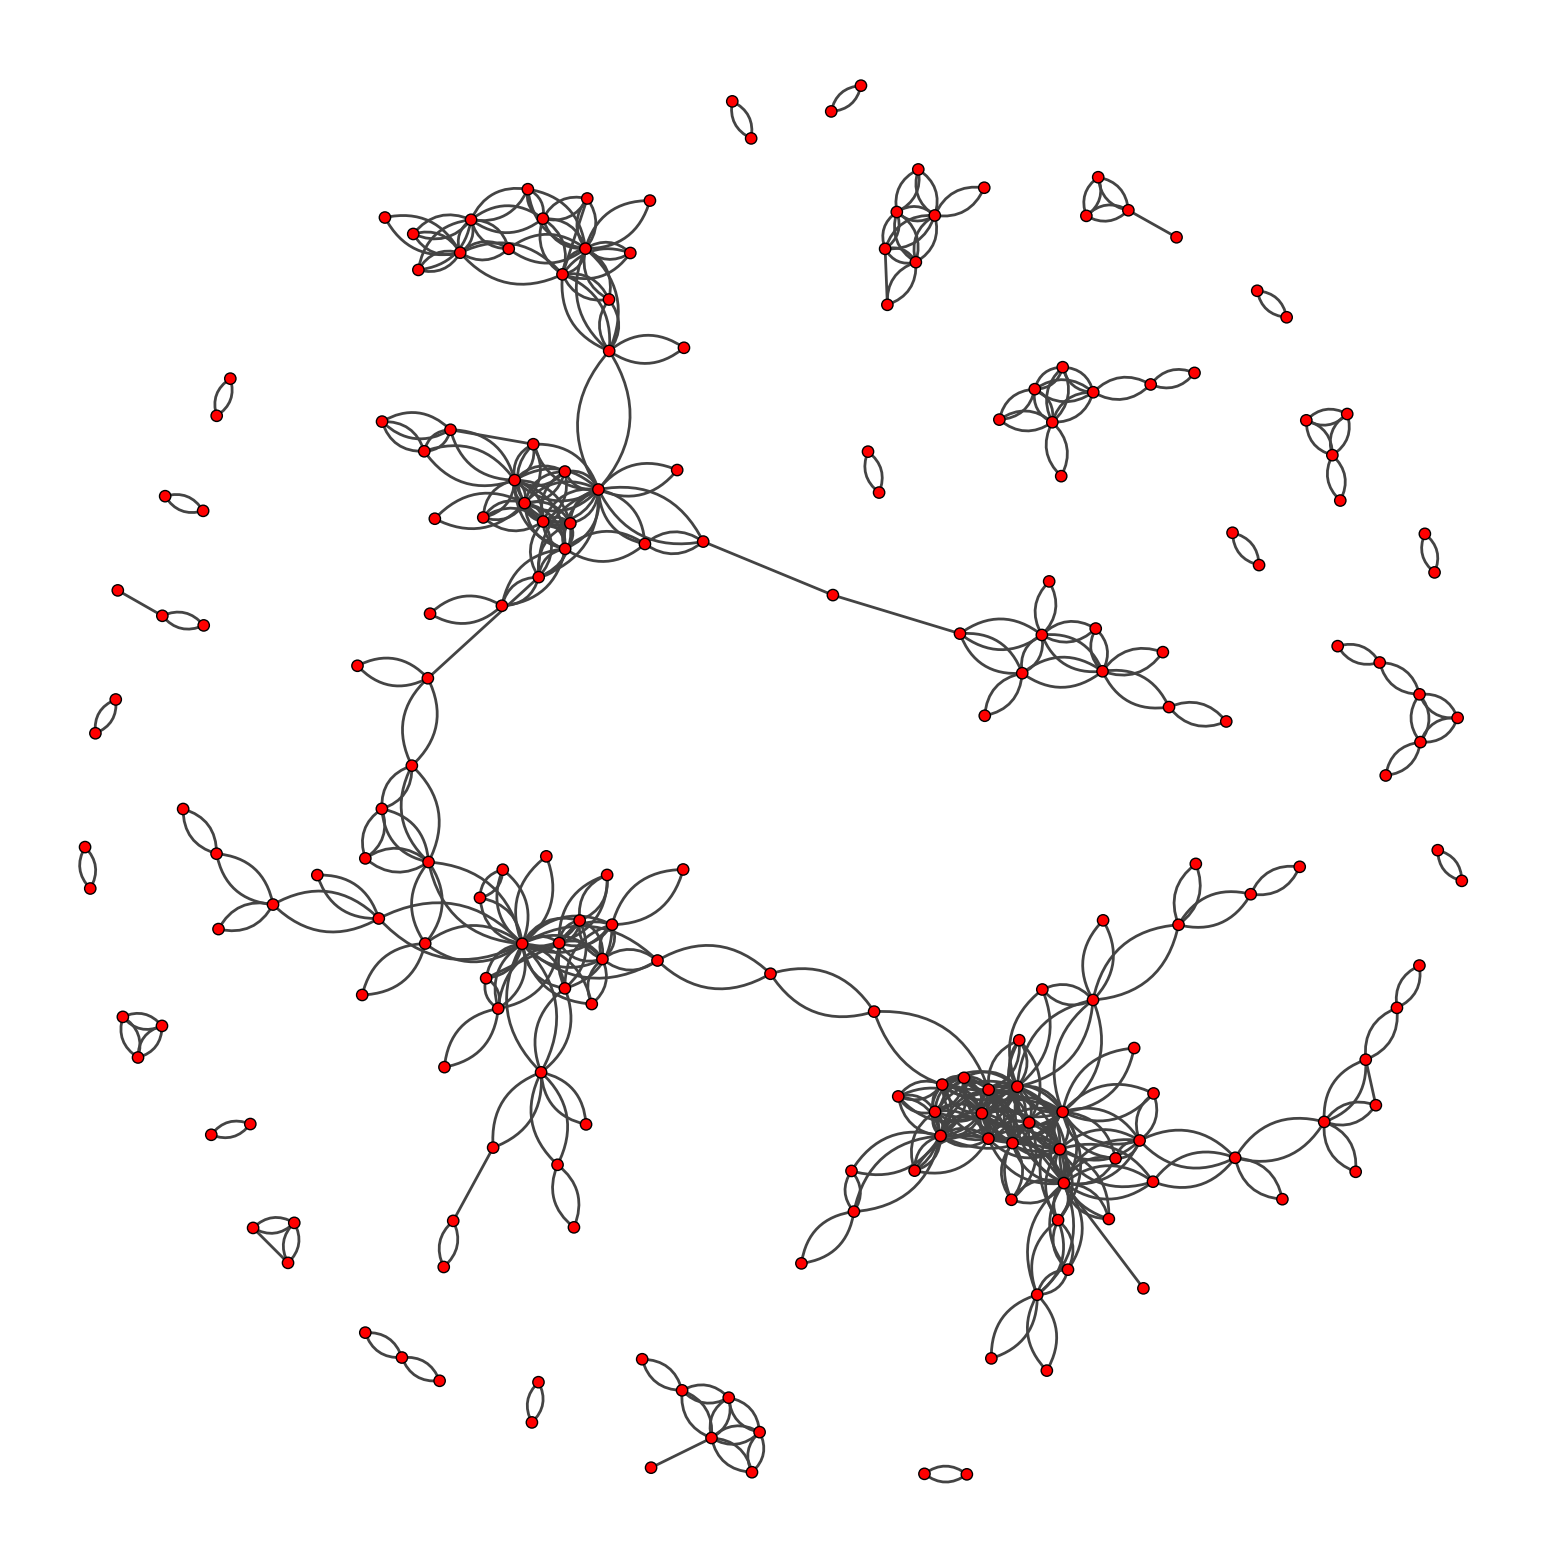

In [24]:
plot_igraph_to_file(graph, fname="../out/correlation_sequencing_0.5")

### Coherence
**TODO:** Explain what coherence is and why it may be efficient.

In [26]:
def coh(x, y, fs: int=20, f_range: Tuple[int, int]=(1, 1000,)) -> float:
    f, c = coherence(x, y, fs)
    f_idx = np.logical_and(f >= f_range[0], f <= f_range[1])
    return float(np.mean(c[f_idx]))

  0%|          | 0/519 [00:00<?, ?it/s]

/tmp/ipykernel_491/1746057977.py:47: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rho_values)


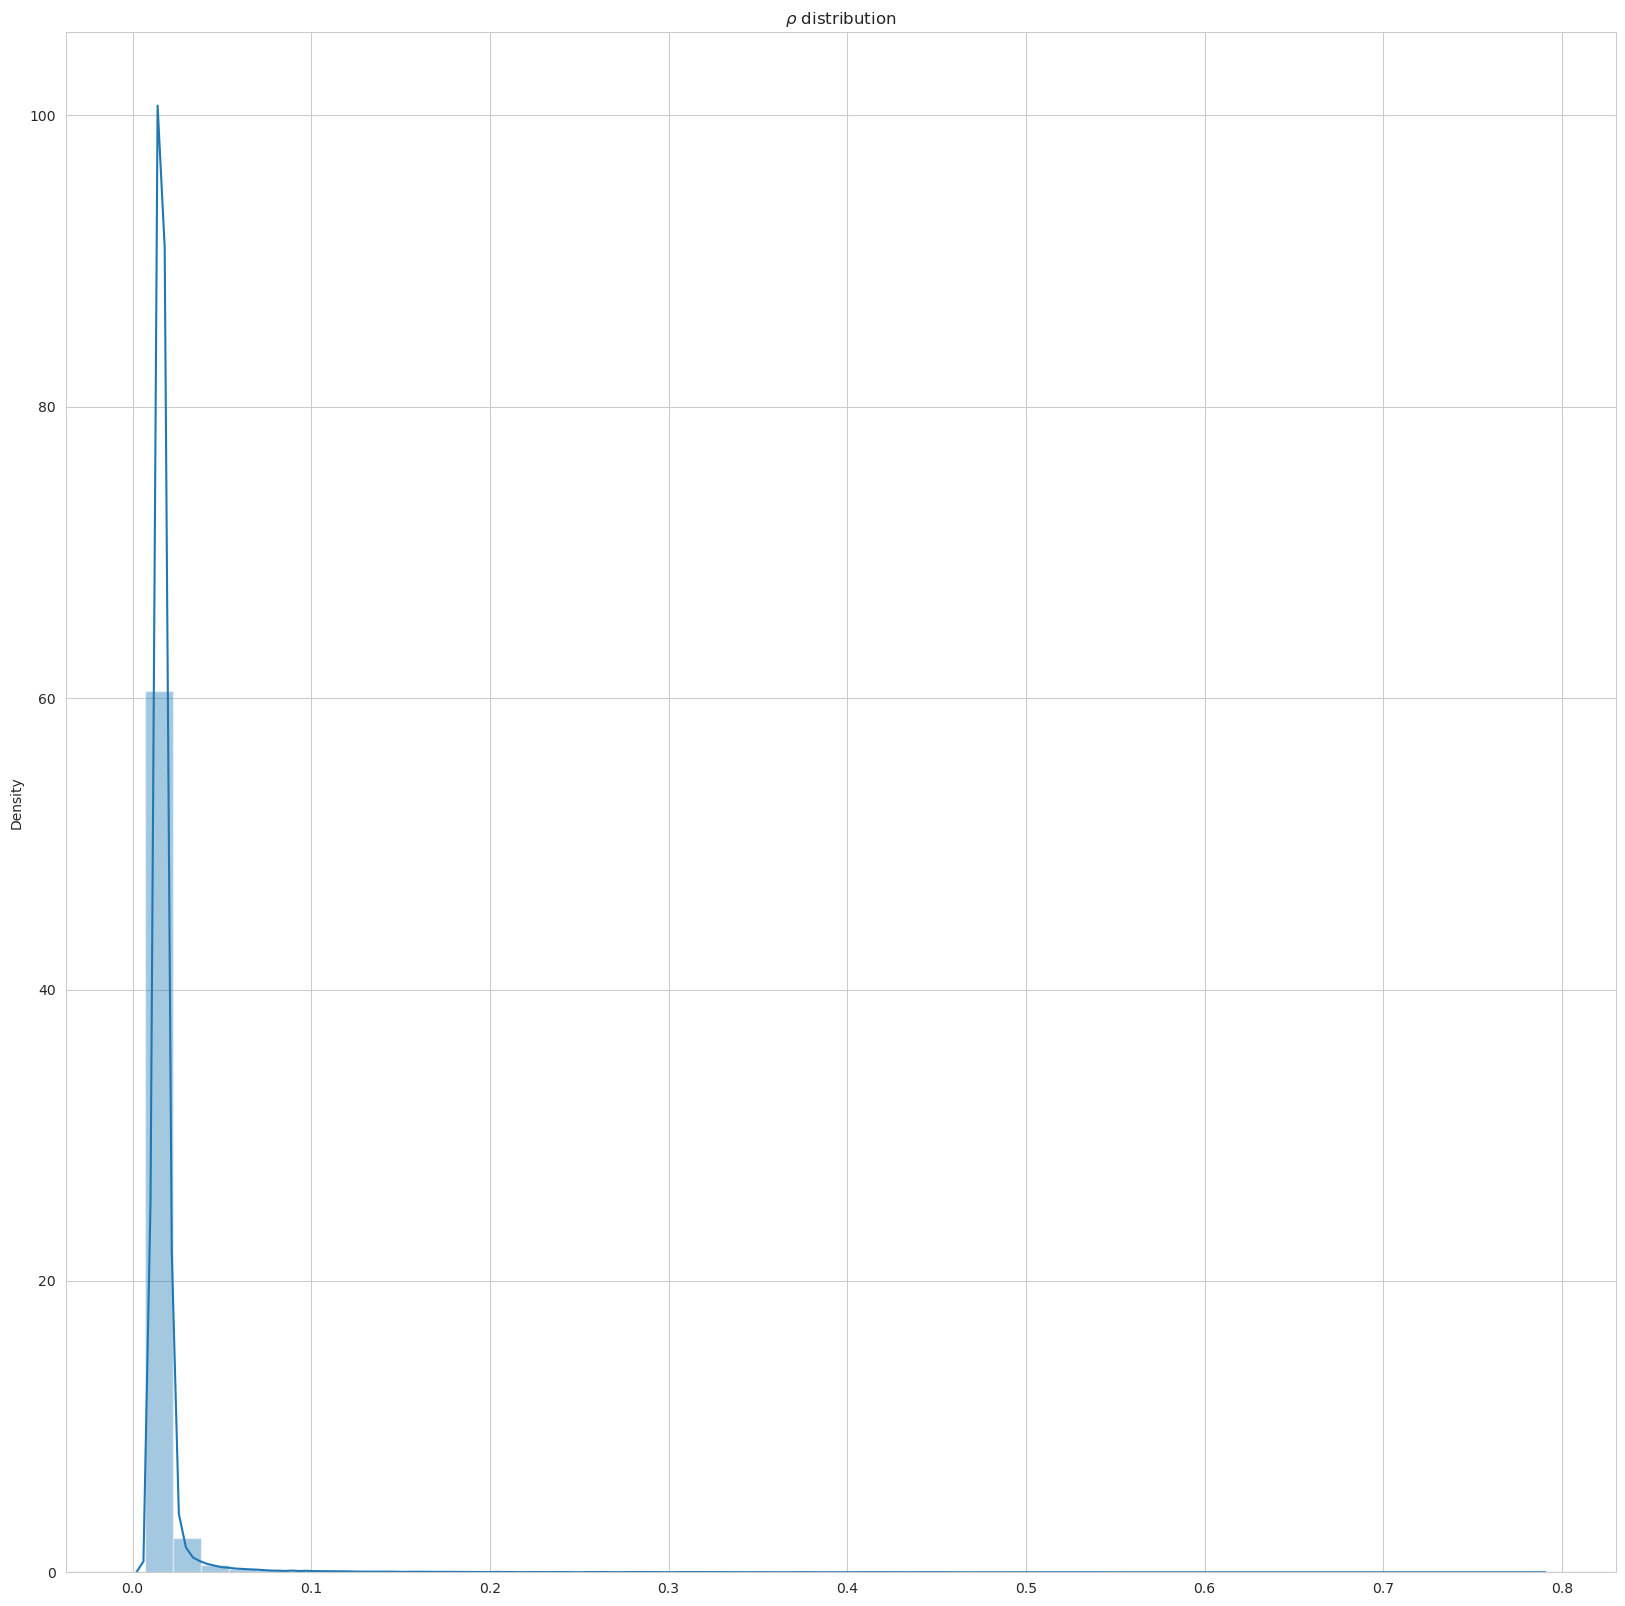

In [32]:
graph = build_graph(coh, 0.1, figname="coh_dist_full")

  0%|          | 0/439 [00:00<?, ?it/s]

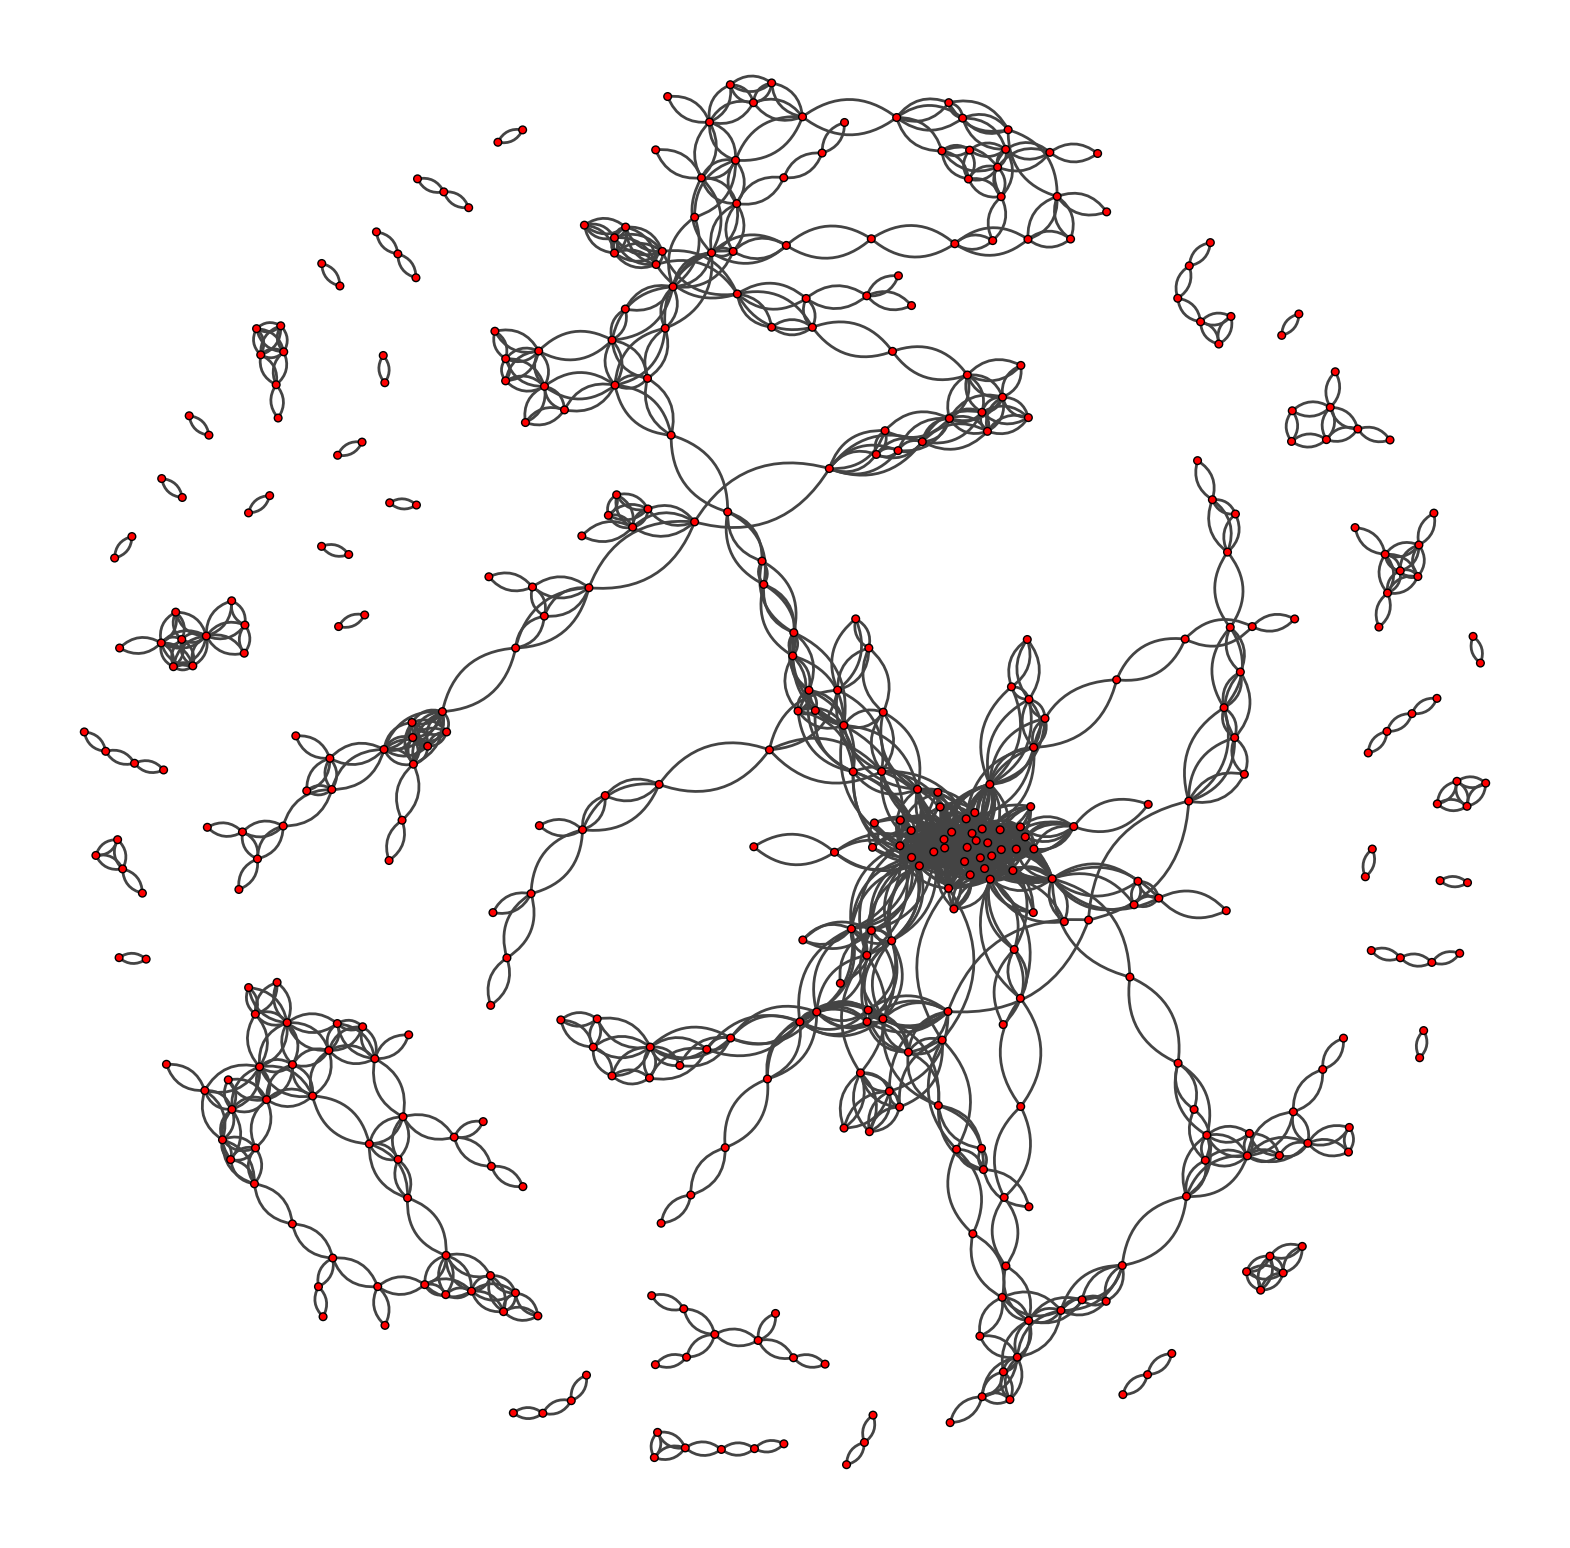

In [33]:
plot_igraph_to_file(graph, "../out/coherence_sequencing")

In [15]:
plot_graph_pyvis(graph, 'coherence_sequencing')

  0%|          | 0/191 [00:00<?, ?it/s]

Visualizing 328 edges
There is 191 nodes in graph
../out/coherence_sequencing.html


  0%|          | 0/519 [00:00<?, ?it/s]

/tmp/ipykernel_491/1746057977.py:47: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rho_values)


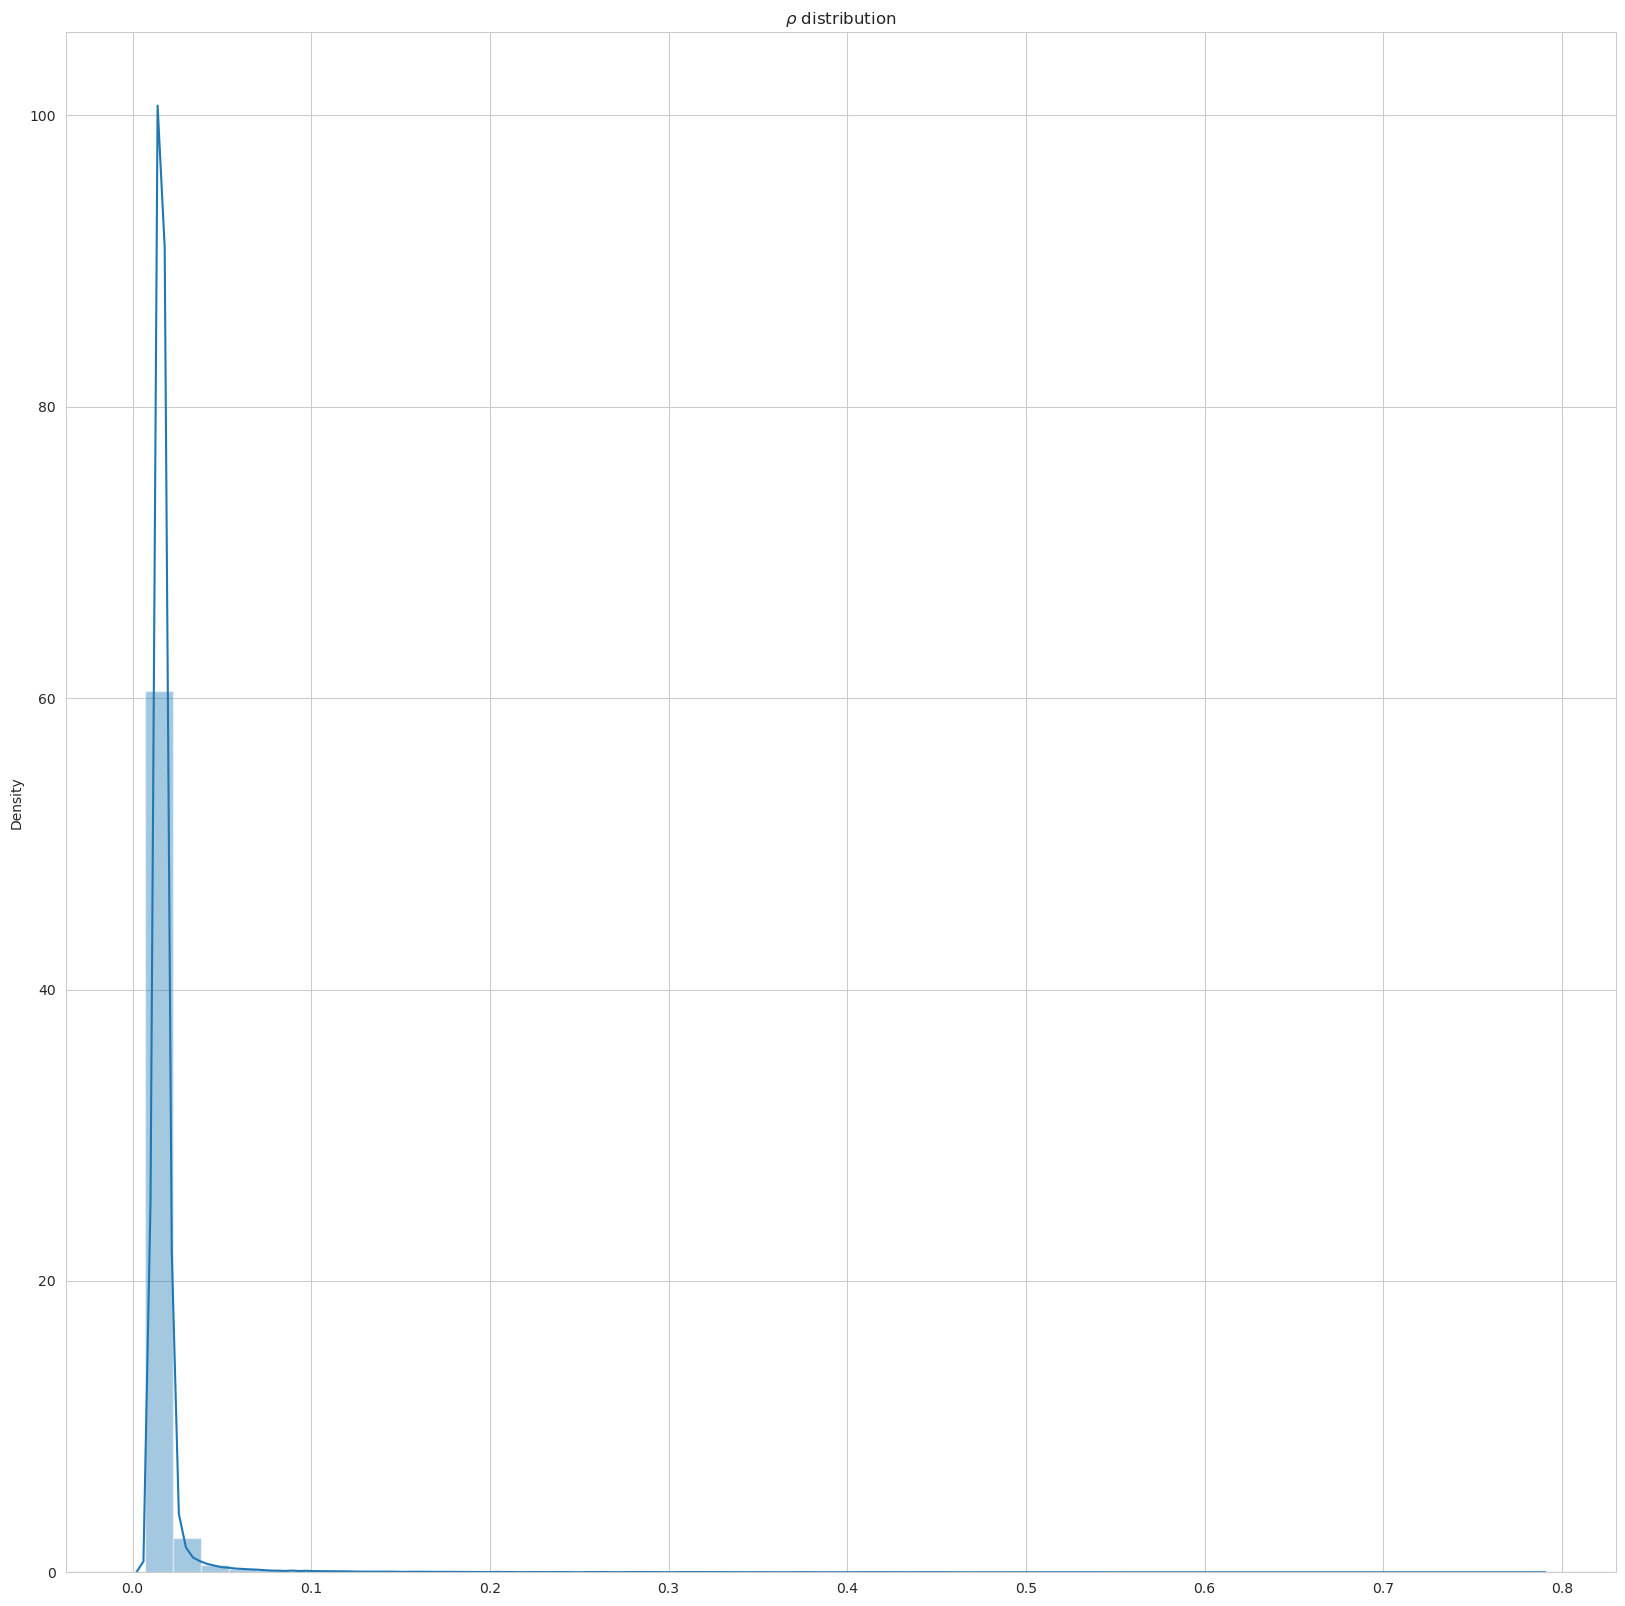

In [34]:
graph = build_graph(coh, 0.2, figname="coh_dist_full")

  0%|          | 0/312 [00:00<?, ?it/s]

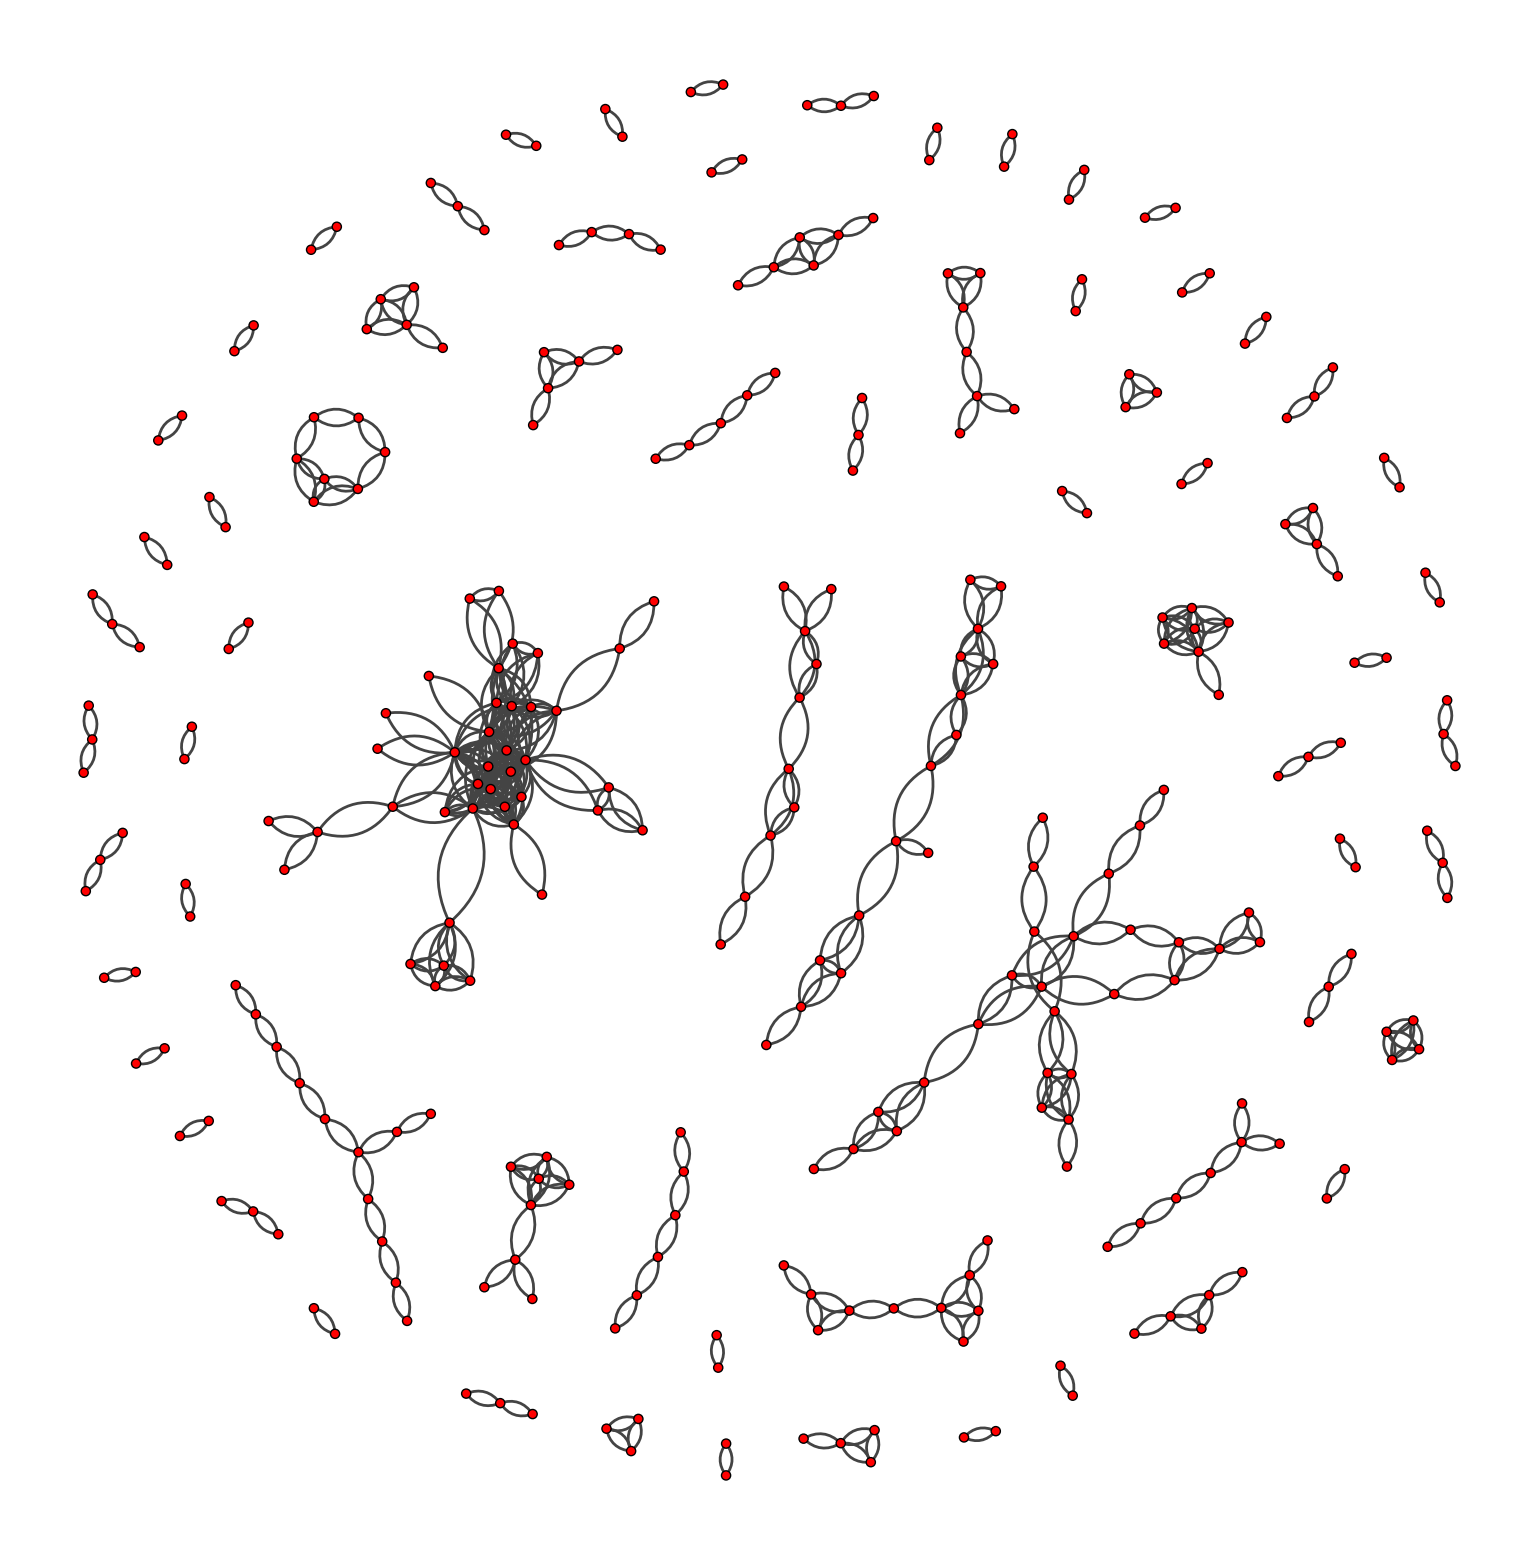

In [35]:
plot_igraph_to_file(graph, "../out/coherence_sequencing_0.2")

## Position similarity
In this section we would perform coherence and correlation sequencing but also with including $x$ and $y$ position of a mouse as well as $\Delta x$ and $\Delta y$

### With $x$ and $y$


#### Correlation

In [ ]:
graph = build_graph(lambda a, b: abs(pearsonr(a, b).statistic), 0.33, exclude_columns=("time_s",))

In [ ]:
plot_graph(graph)

In [ ]:
plot_graph_pyvis(graph, "correlation_xy_sequencing")

In [ ]:
graph['x']

In [ ]:
graph['y']

#### Coherence

In [ ]:
graph = build_graph(coh, 0.05, exclude_columns=("time_s",))

In [ ]:
plot_graph(graph)

In [ ]:
plot_graph_pyvis(graph, "coherence_xy_sequencing")

In [ ]:
graph['x']

In [ ]:
graph['y']

### With $\Delta x$ and $\Delta y$
Here we would try to identify which neurons react to change of position of a rodent.

In [ ]:
delta_x = np.diff(df_norm.x)
delta_y = np.diff(df_norm.y)

In [ ]:
df_with_delta = df_norm[1:].copy(True)
df_with_delta = df_with_delta.assign(dx=delta_x, dy=delta_y)
df_with_delta

#### Correlation

In [ ]:
graph = build_graph(lambda a, b: abs(pearsonr(a, b).statistic), 0.33, dataframe=df_with_delta)

In [ ]:
plot_graph(graph)

In [ ]:
plot_graph_pyvis(graph, "correlation_dxdy_sequencing", dataframe=df_with_delta)

In [ ]:
graph['dx']

In [ ]:
graph['dy']

#### Coherence

In [ ]:
graph = build_graph(coh, 0.05, dataframe=df_with_delta)

In [ ]:
plot_graph(graph)

In [ ]:
plot_graph_pyvis(graph, "coherence_dxdy_sequencing", dataframe=df_with_delta)

In [ ]:
graph['dx']

In [ ]:
graph['dy']

# Metric analysis
In order to understand better structure of our graph we may further analyse metrics of similarity between nodes.

In [ ]:
class Edge:
    def __init__(self, src: Any, dst: Any, rho: float):
        self.src = src
        self.dst = dst
        self.rho = rho

In [ ]:
# Generic method for building graph
def build_graph(rho: Callable,  n_eps: int = 1,
                exclude_columns: Tuple[str] = ('x', 'y', 'time_s',),
                use_lag: bool = True, dataframe=df_norm) -> Tuple[Dict[str, List[str]], List[Edge]]:
    """
    Builg graph with arbitary metrics
    :param dataframe: pd.DataFrame: a dataframe with neuron activity
    :param rho: Callable: metric which accepts two time series and returns float similarity value
    :param mu_min: float: minimal value of metric to state that one neuron activation depends on other
    :param n_eps: int: integer value of epsilon for shifting dataset, takes effect only if lag enabled
    :param exclude_columns: List[str] columns which should be ignored
    :param: use_lag: bool: Whether to lag time series
    :return: Tuple[Dict[str, List[str]], List[Edge]]: graph representation in from of mapping
                                   node name and list of node name it flows to and list of all
                                   edges graph.
    """
    df_neurons = dataframe.drop(list(exclude_columns), axis=1)
    graph = defaultdict(lambda: list())
    rho_avg = 0.0
    n = 0
    rho_values = list()
    edges = list()
    for a_column in tqdm(df_neurons.columns):
        if a_column in exclude_columns:
            continue
        for b_column in df_neurons.columns:
            if a_column == b_column:
                continue
            if b_column in exclude_columns:
                continue
            n += 1
            a = df_neurons[a_column]
            b = df_neurons[b_column]
            if use_lag:
                a = a[:-n_eps]
                b = b[n_eps:]
            result = rho(a, b)
            rho_values.append(result)
            rho_avg += result
            if not isinstance(result, float):
                raise TypeError(f"rho should return float, got {result}")
            graph[a_column].append(Edge(a_column, b_column, result))
            edges.append(Edge(a_column, b_column, result))
    if not any_in([None, math.inf, -math.inf], rho_values):
        plt.title("$\\rho$ distribution")
        sns.distplot(rho_values)
        plt.show()
    else:
        print("NaNs detected in rho values, would not build plots")
    return graph, edges

In [ ]:
graph, edges = build_graph(coh)

# Model
In this section we would try modeling connections between neurons in a very direct way. Suppose we have got the connection between neurons $a$ and $b$ with metric $\rho$. Ideally metric means our confidence of how one neuron influences other. Then ideal model is simply a function $f: \mathbb{R}^2\to\mathbb{R}$ of form $f(a_{t}, \rho) = b_{t+1}$. Our task is to approximate this function. Further we would improve such model by removing some of assumptions.

 In order to assess quality of model we would rely at MSE for simplicity.

## Prepare dataset

In [ ]:
df_neurons = df_norm.drop(["x", "y", "time_s"], axis=1)
df_neurons

In [ ]:
def make_dataset(rho_min: float) -> pd.DataFrame:
    activity_src, activity_dst, rho = list(), list(), list()
    rho = list()
    for edge in tqdm(edges):
        if edge.rho < rho_min:
            continue
        a = list(df_neurons[edge.src])
        b = list(df_neurons[edge.dst])
        a = a[:-1]
        b = b[1:]
        assert len(a) == len(b), "Wrong sizes of timeseries"
        activity_src += a
        activity_dst += b
        rho += [edge.rho] * len(a)
    return pd.DataFrame(dict(activity_src=activity_src, activity_dst=activity_dst, rho=rho))

In [ ]:
df_activity = make_dataset(0.05)

## Analyse dataset

In [ ]:
df_activity_f = df_activity[df_activity.rho > 0.64]

In [ ]:
plt.title("Destination activity by source activity($\\rho>0.64$)")
plt.scatter(df_activity_f.activity_src, df_activity_f.activity_dst)
plt.show()

In [ ]:
df_activity_f = df_activity[df_activity.rho > 0.61]
plt.title("Destination activity by source activity($\\rho>0.61$)")
plt.scatter(df_activity_f.activity_src, df_activity_f.activity_dst)
plt.show()

### Plot samples

In [ ]:
df_activity_f = df_activity.sample(frac=0.001)
plt.title("Destination activity by source activity($0.001\\%$ random sample)")
plt.scatter(df_activity_f.activity_src, df_activity_f.activity_dst)
plt.show()

### Look at $\rho$ ranges

In [ ]:
df_activity_f = df_activity[df_activity.rho > 0.49]
df_activity_f = df_activity_f[df_activity_f.rho < 0.5]
plt.title("Destination activity by source activity($\\rho\\in (0.49; 0.5)$)")
plt.scatter(df_activity_f.activity_src, df_activity_f.activity_dst)
plt.show()

In [ ]:
df_activity_f = df_activity[df_activity.rho > 0.45]
df_activity_f = df_activity_f[df_activity_f.rho < 0.46]
plt.title("Destination activity by source activity($\\rho\\in(0.45; 0.46)$)")
plt.scatter(df_activity_f.activity_src, df_activity_f.activity_dst)
plt.show()

### Activity analysis

#### Look at low activity region

In [ ]:
df_activity_f = df_activity[df_activity.activity_src < 0.01]
df_activity_f = df_activity_f[df_activity_f.activity_dst < 0.01]
plt.title("Destination activity by source activity(low activity)")
plt.scatter(df_activity_f.activity_src, df_activity_f.activity_dst)
plt.show()

In [ ]:
df_activity_f = df_activity[df_activity.activity_src < 0.03].sample(frac=0.01)
plt.title("Destination activity by source activity(low activity, $1\\% sample$)")
plt.scatter(df_activity_f.activity_src, df_activity_f.activity_dst)
plt.show()

### Explaratory analysis conclusion
We may see that relation of between neural activity while having a linear relation has high variance and so unlikely may be used for developing a suitable model. Such problem may have occured due to learning process which actually change the weights of connections between neurons and so may lead to biased coherence values.
Despite of this problems we would try some simple models for estimation.